<a href="https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Denoising%20with%20Gaussian-smooth%20filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising with Gaussian-smooth filter

Welcome to the second part of the denoising series, in the [previous tutorial](https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Denoising%20with%20mean-smooth%20filter.ipynb#scrollTo=Rbm-Duk6IaiQ), we saw how a mean-smooth filter works. In this tutorial, we will look at a slight adaptation of the mean-smooth filter, the Gaussian smoothing filter.

## Load packages

We will download [splearn](https://github.com/jinglescode/python-signal-processing), a package that consists of datasets, common signal processing functions and machine learning model architectures.

In [1]:
#@title Import packages
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import copy

sys.path.append("..")
from splearn.data.generate import generate_signal # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/data/generate.py

In [2]:
#@title Functions used in this tutorial

## create Gaussian kernel
def create_gaussian_filter(fwhm, kernal_size, plot=False):
    
    # normalized vector
    k = kernal_size
    time = np.arange(-k,k)

    # create Gaussian window
    gauswin = np.exp( -(4*np.log(2)*time**2) / fwhm**2 )

    # compute empirical full width at half maximum (FWHM)
    pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
    prePeakHalf = np.argmin( (gauswin-.5)**2 )
    empFWHM = time[pstPeakHalf] - time[prePeakHalf]

    if plot:
        plt.plot(time,gauswin,'ko-')
        plt.plot([time[prePeakHalf],time[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

        plt.title('Gaussian kernel (requested FWHM ' + str(fwhm) + ', ' + str(empFWHM) + ' achieved)')
        plt.xlabel('Time (ms)')
        plt.ylabel('Gain')

        plt.show()
    
    # then normalize Gaussian to unit energy
    gauswin = gauswin / np.sum(gauswin)

    return gauswin


def apply_gaussian_filter(input_signal, gauswin, kernal_size, plot=False):
    # apply the Gaussian-smooth filter

    k = kernal_size
    n = len(input_signal)

    # initialize filtered signal vector
    filter_signal = copy.deepcopy(input_signal)

    # implement the running mean filter
    for i in range(k+1,n-k-1):
        # each point is the weighted average of k surrounding points
        filter_signal[i] = np.sum( input_signal[i-k:i+k]*gauswin )

    if plot:
        # plot and compare
        plt.plot(input_signal,'r',label='Original')
        plt.plot(filter_signal,'k',label='Gaussian-filtered')

        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.title('Gaussian smoothing filter')
        plt.legend()

    return filter_signal

## Introduction

The Gaussian-smooth filter works almost exactly the same as [mean-smooth](https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Denoising%20with%20mean-smooth%20filter.ipynb#scrollTo=Rbm-Duk6IaiQ) filter except instead of averaging surrounding points, we smooth each point with a [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function). In the mean-smooth filter, we perform the `np.mean` operation, this means that it performs summation and then dividing by the total number of points in the kernel. Using the Gaussian-smooth filter, we do not do that, instead, we are applying the Gaussian function across every point. To illustrate this in this tutorial, we will attempt to smooth a signal using Gaussian filter. Here is our noisy signal.

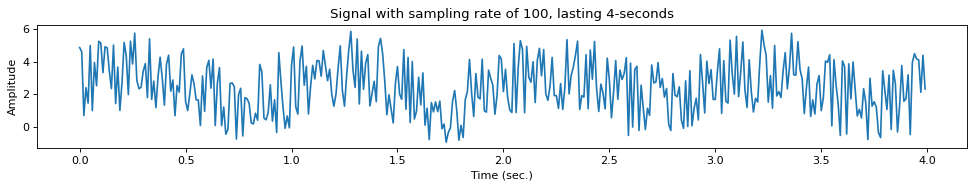

In [3]:
# generate a noisy signal
figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
signal_noisy = generate_signal(
    length_seconds=4, 
    sampling_rate=100, 
    frequencies=[1],
    add_noise=5,
    plot=True
)

And here is how an ideal gaussian looks like this, it goes up to 1 in the middle and goes down to 0 on both sides. Technically it never gets to exact 0, but it gets very close to 0. The area under the function (or the curve) is 1.

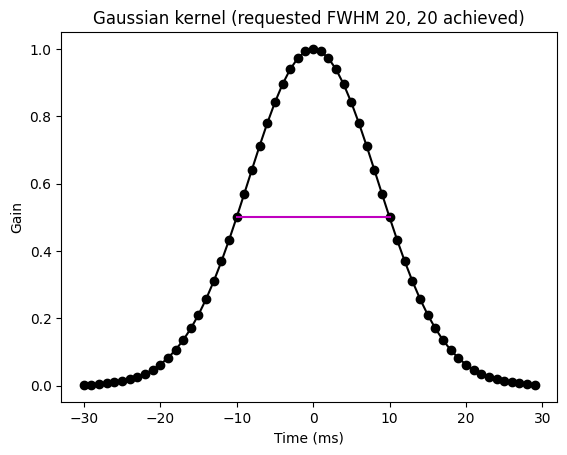

In [4]:
fwhm = 20
kernal_size = 30

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

This is the filtered signal after applying the gaussian-smooth filter. Where red is the original noisy signal, and the black line is the filtered signal. The rough edges on both ends are edge effects, we explored this in the [previous tutorial](https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Denoising%20with%20mean-smooth%20filter.ipynb#scrollTo=Rbm-Duk6IaiQ). 


(400,)


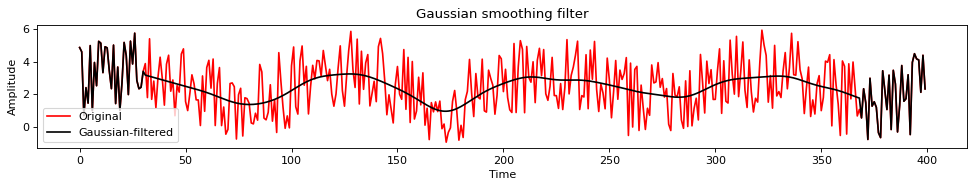

In [5]:
figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
filter_signal_f20_k30 = apply_gaussian_filter(
    input_signal=signal_noisy, 
    gauswin=gaussian_filter, 
    kernal_size=kernal_size,
    plot=True
)

print(filter_signal_f20_k30.shape)

## How to determine a good gaussian-smooth filter

There are 2 parameters that will affect the gaussian filter. We will explore these parameters and plot the gaussian as it is important so we know how to tune the parameters for our smoothing function. 

### Full width at half maximum

According to Wikipedia, [Full width at half maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum) (FWHM) is 

> the difference between the two values of the independent variable at which the dependent variable is equal to half of its maximum value. In other words, it is the width of a spectrum curve measured between those points on the y-axis which are half the maximum amplitude.

A gaussian-smooth filter allows us to tweak the FWHM parameter, which is the width of the gaussian, the distance between the two points that are closest to 50% gain (the middle on the y-axis). So you can think of gaussian as a "gain function", where `y=1` is the maximum gain, and `y=0.5` is 50% gain, and the effective filter's sliding window's width is the 2 points along the x-axis at FWHM (50% gain). Thus, by adjusting the FWHM, you are effectively tuning how much smoothing you want to apply to the data. 



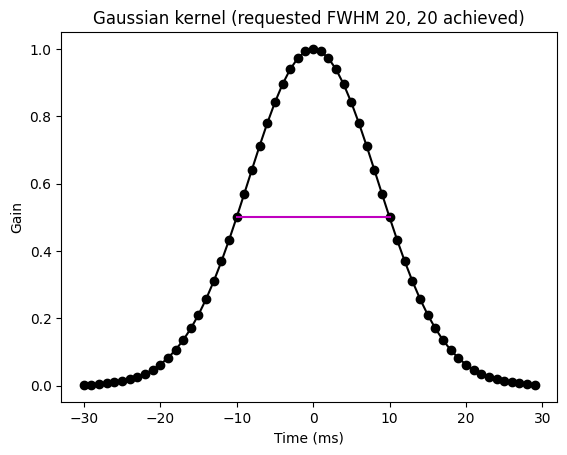

In [6]:
#@title
fwhm = 20
kernal_size = 30

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

In short, adjusting FWHM will widen or narrow the size of the filter. 

Let's compare the results if we reduce FWHM, compare `FWHM=20` and `FWHM=5`.

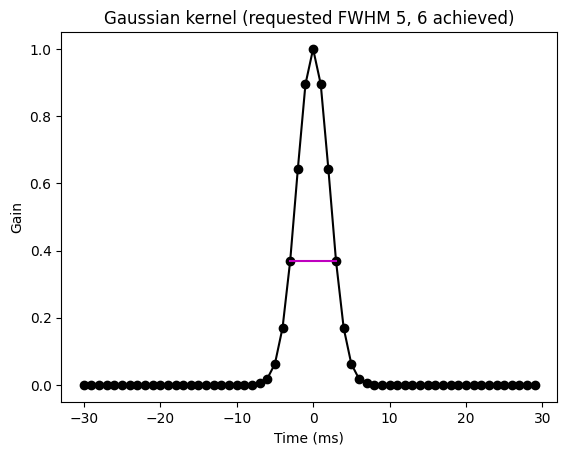

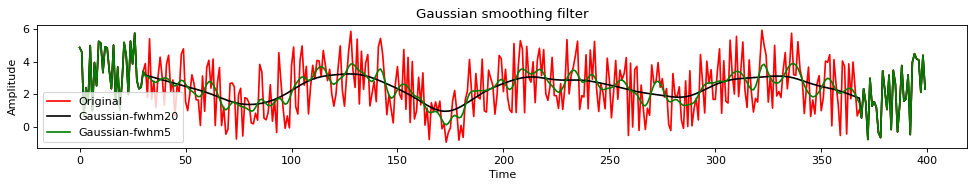

In [7]:
#@title

fwhm = 5
kernal_size = 30

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

filter_signal_f5_k30 = apply_gaussian_filter(
    input_signal=signal_noisy, 
    gauswin=gaussian_filter, 
    kernal_size=kernal_size,
    plot=False
)

figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian-fwhm20')
plt.plot(filter_signal_f5_k30,'g',label='Gaussian-fwhm5')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter')
plt.show()

As we can observe from the result, lower FWHM produces a rougher curve (green line, `FWHM=5`) compared to the black line (`FWHM=20`). 

Let's see what happens when we increase it.

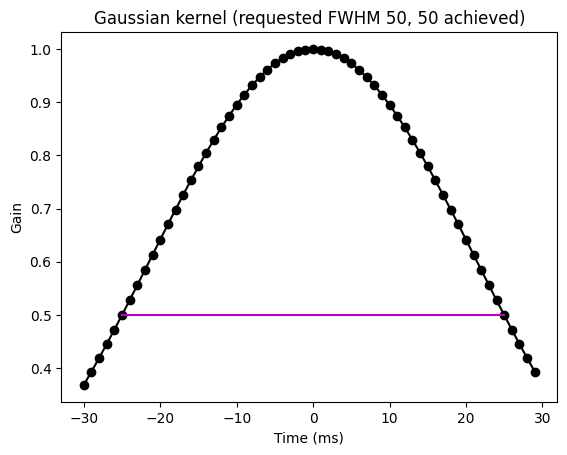

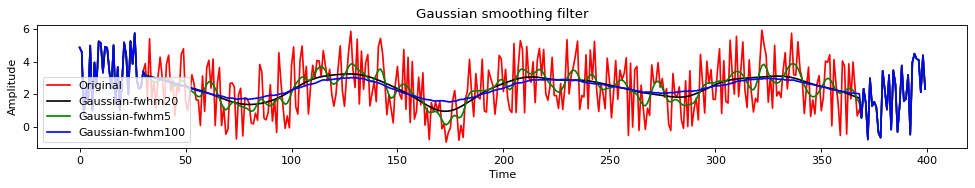

In [8]:
#@title

fwhm = 50
kernal_size = 30

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

filter_signal_f100_k30 = apply_gaussian_filter(
    input_signal=signal_noisy, 
    gauswin=gaussian_filter, 
    kernal_size=kernal_size,
    plot=False
)

figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian-fwhm20')
plt.plot(filter_signal_f5_k30,'g',label='Gaussian-fwhm5')
plt.plot(filter_signal_f100_k30,'b',label='Gaussian-fwhm100')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter')
plt.show()

Indeed, higher FWHM will result in smoother curves. 

But let's look at the gaussian kernel, it is no longer ranging from 0 to 1, and we do not see a long tail anymore. This shows that by increasing the FWHM parameter, we have to increase the kernel window size as well. Bad kernels can have unintended outcomes.

### Kernel window size

The second parameter that will affect the gaussian filter is the kernel window size. Now, let's observe the effects of the kernel window, what happen when we increase the kernel size (`k=30` vs `k=100`)?

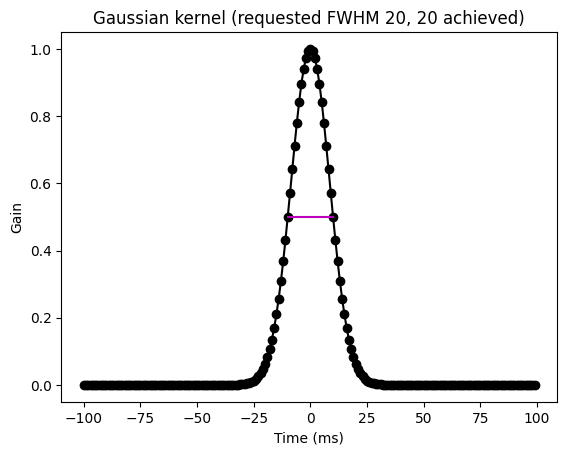

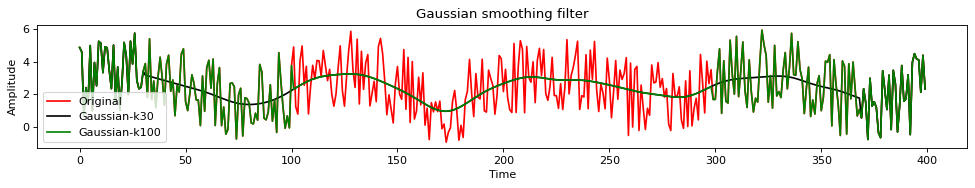

In [9]:
#@title

fwhm = 20
kernal_size = 100

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

filter_signal_f20_k100 = apply_gaussian_filter(
    input_signal=signal_noisy, 
    gauswin=gaussian_filter, 
    kernal_size=kernal_size,
    plot=False
)

figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian-k30')
plt.plot(filter_signal_f20_k100,'g',label='Gaussian-k100')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter')
plt.show()

As you can see, increasing the kernel size (`k=100`) will result in more edge effects (the green noisy portion), these are the portion of the signal that the gaussian-smooth filter is not applied. As such, this is not acceptable, as you are "losing" a large part of the original data. Thus, when we inspect the Gaussian kernel, we should try to minimize the long tails, keeping the kernel size as small as possible. 

What happen if we reduce the kernel size? (`k=30` vs `k=10`)


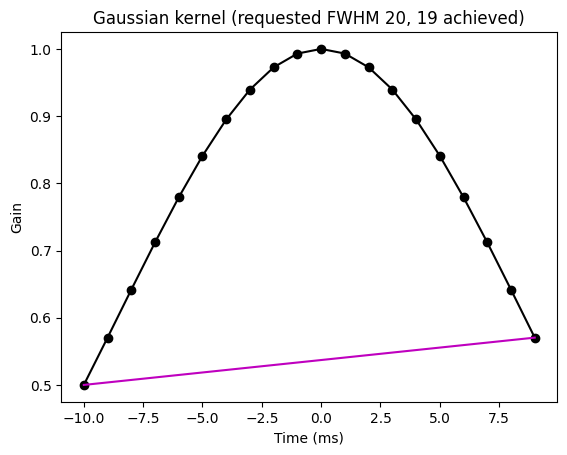

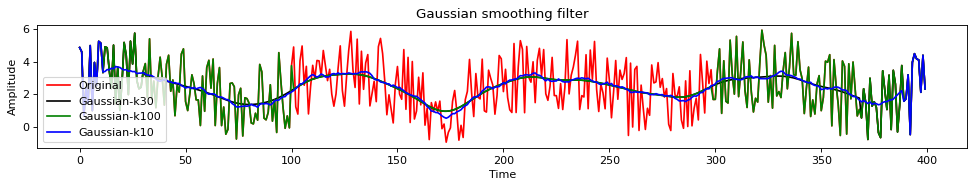

In [10]:
#@title

fwhm = 20
kernal_size = 10

gaussian_filter = create_gaussian_filter(
    fwhm=fwhm, 
    kernal_size=kernal_size, 
    plot=True
)

filter_signal_f20_k10 = apply_gaussian_filter(
    input_signal=signal_noisy, 
    gauswin=gaussian_filter, 
    kernal_size=kernal_size,
    plot=False
)

figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian-k30')
plt.plot(filter_signal_f20_k100,'g',label='Gaussian-k100')
plt.plot(filter_signal_f20_k10,'b',label='Gaussian-k10')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter')
plt.show()

Though by reducing the kernel window, we have lesser edge effects (in blue), but the Gaussian kernel is no longer ranging from 0 to 1. This might produces undesirable results. Thus, though we want to minimize the kernel size, it cannot be too small.

Thus, it is important to plot the Gaussian filter, so we know how to tune the parameters to design our smoothing function before applying to the signal. 

To make a desired Gaussian filter, we have to make sure that the lower bound goes down to 0, and the upper bound is 1. We also want to make sure that the long tail is not too long, so as to reduce the edge effects.

## Compare Gaussian-smooth and mean-smooth filter (when to use the Gaussian-smooth filter?)

Let's compare and see the differences between Gaussian-smooth and mean-smooth filter.


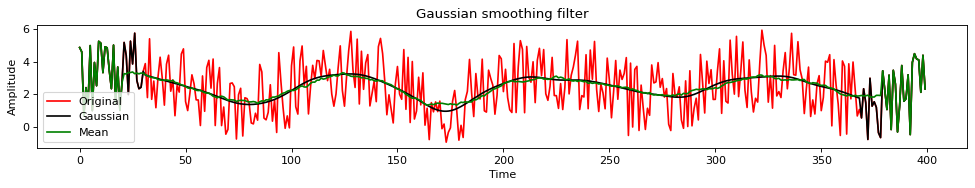

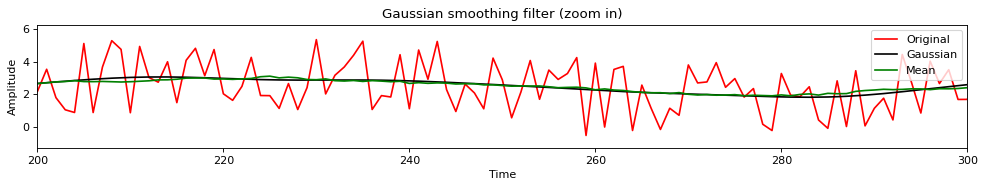

In [11]:
#@title

# initialize filtered signal vector
filter_signal_mean = copy.deepcopy(signal_noisy)

filter_window = 30
n = len(signal_noisy)

# implement the running mean filter
filter_window = 20
for i in range(filter_window+1,n-filter_window-1):
    # each point is the average of k surrounding points
    filter_signal_mean[i] = np.mean(signal_noisy[i-filter_window:i+filter_window])

# plot
figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian')
plt.plot(filter_signal_mean,'g',label='Mean')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter')
plt.show()

# plot zoom in
figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(signal_noisy,'r',label='Original')
plt.plot(filter_signal_f20_k30,'k',label='Gaussian')
plt.plot(filter_signal_mean,'g',label='Mean')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Gaussian smoothing filter (zoom in)')
plt.xlim((200,300))
plt.show()

Gaussian-smooth filter (in black) tends to smooth the data to be a bit smoother compared to mean-smooth filter (in green). 

This does not mean that one is better than the other, it depends on the specific applications. It is important to be aware of different filters type and how to use them.


# Endnotes

Thanks for checking out this tutorial. I hope it has been helpful. If you find any mistakes or have any questions, please do not hesitate to [submit an issue](https://github.com/jinglescode/python-signal-processing/issues). Feel free to connect with me on [GitHub](https://github.com/jinglescode) and [LinkedIn](https://www.linkedin.com/in/jingles).